In [1]:
#TRABALHO FINAL CMP197
#SEGMENTADOR

import cv2
import numpy as np
import matplotlib.image as plti
import matplotlib.pyplot as plt
import skimage.morphology as skimo
import skimage.measure as skime
%matplotlib inline

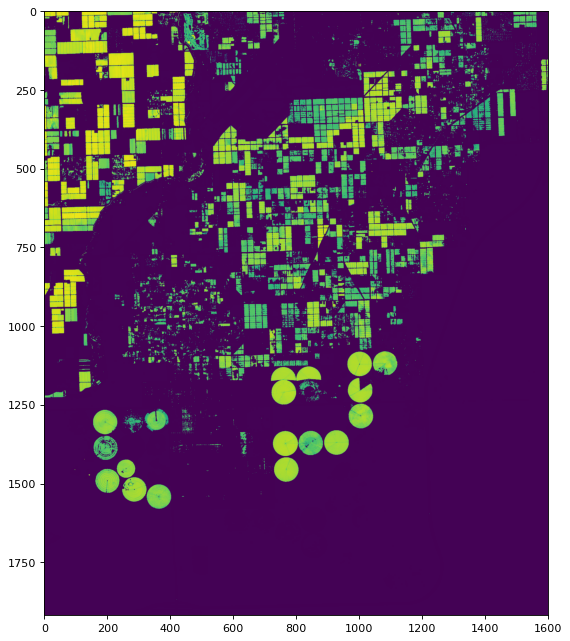

In [2]:
#LÊ IMAGEM 
#ndvi = plt.imread('Imagens/ONLY_PIVOTS_1.png', -1)
ndvi = plt.imread('YUMA_VALLEY_TESTE.png', -1)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(ndvi, cmap='gray')
plt.show()

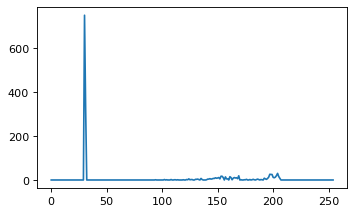

In [3]:
#CALCULA HISTOGRAMA e REMOVE FUNDO
ndvi_gray = cv2.imread('YUMA_VALLEY_TESTE.png', cv2.IMREAD_GRAYSCALE)

hist = cv2.calcHist(ndvi_gray,[0], None, [255], [0,255], accumulate=False)    #Calcula histograma

plt.figure(figsize=(5, 3), dpi=80)
#plt.imshow(th3, cmap='gray')
plt.plot(hist)
plt.show()

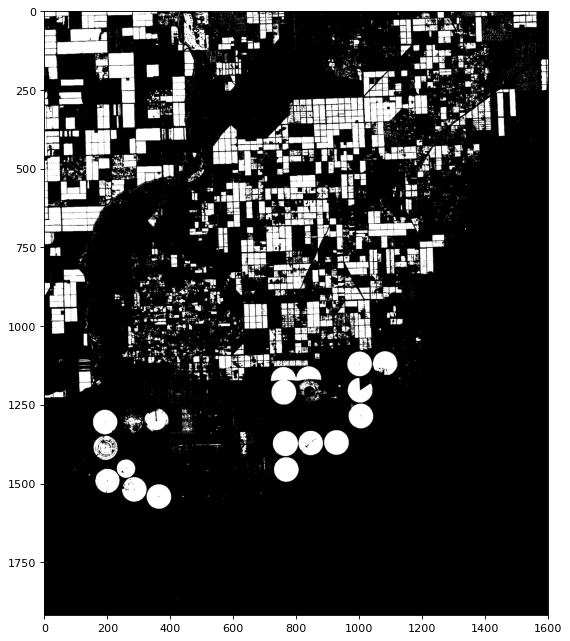

In [4]:
#REMOVE O FUNDO
ret, img_bin = cv2.threshold(ndvi_gray, 50, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10, 10), dpi=80)
# plt.subplot(1,3,2)
# plt.imshow(img_bin, cmap='gray')
plt.subplot(1,1,1)
plt.imshow(img_bin, cmap='gray')
# plt.subplot(1,2,2)
# plt.plot(hist2)
plt.show()

In [5]:
#hough circular
ndvi_gray = cv2.imread('YUMA_VALLEY_TESTE.png', cv2.IMREAD_GRAYSCALE)

ret3,th3 = cv2.threshold(ndvi_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

ndvi_gray = cv2.medianBlur(np.array(th3), 5);
ndvi_gray_orig = th3

rows = ndvi_gray.shape[0]

def circles(imagem):
  circles = cv2.HoughCircles(imagem, cv2.HOUGH_GRADIENT, 1, 10,
                                param1=90, param2=18,
                                minRadius=25, maxRadius=55)
  return circles

circles = circles(ndvi_gray)

In [6]:
ndvi = plt.imread('YUMA_VALLEY_TESTE.png', -1)
if circles is not None:
  circles = np.uint16(np.around(circles))
  for i in circles[0, :]:
    center = (i[0], i[1])
    # circle center
    #cv2.circle(ndvi, center, 1, (0, 100, 100), 1)
    # circle outline
    radius = i[2]
    #cv2.circle(ndvi, center, radius, (0, 0, 255), 1)

Número de candidatos a pivots encontrados: 19


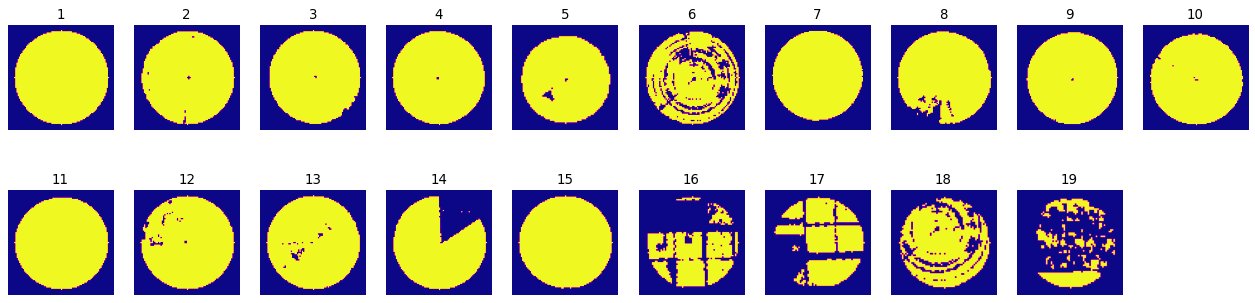

In [7]:
print("Número de candidatos a pivots encontrados:", len(circles[0]))

pivots = []
infos = []
plt.figure(figsize=(20, 5), dpi=80)
ndvi_copy = ndvi
for i in range(0, len(circles[0])):
  infos.append([])
  pivot1x = circles[0][i][0]
  infos[i].append(pivot1x)
  pivot1y = circles[0][i][1]
  infos[i].append(pivot1y)
  pivot1r = circles[0][i][2]
  infos[i].append(pivot1r)

  #máscara
  img = (ndvi[pivot1y-pivot1r-5:pivot1y+pivot1r+5, pivot1x-pivot1r-5:pivot1x+pivot1r+5]*255).astype(np.uint8)
  mask = ((np.zeros(((pivot1r+5)*2, (pivot1r+5)*2)))*255).astype(np.uint8)
  mask1 = cv2.circle(mask, ((pivot1r+5), (pivot1r+5)), pivot1r, (255, 255, 255), cv2.FILLED)

  masked = cv2.bitwise_and(img, img, mask=mask1)
  masked = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
  
  _,thresh1 = cv2.threshold(masked,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  pivots.append(thresh1)

  #nome = 'C:/Users/ugald/OneDrive/00_UFRGS/03_ComputerVision/TrabalhoFinal/Imagens/YUMA_VALLEY_TESTE/teste_' + str(i+148) + '.png'
  #plti.imsave(nome, masked)       

  plt.subplot(2,int(np.ceil(len(circles[0])/2)),i+1)
  plt.axis('off')
  plt.title(i+1)
  plt.imshow(pivots[i], cmap='plasma')

plt.show()  

In [8]:
#informações de coordenadas centrais e raios de todos candidatos a pivot
print(infos) #x, y, raio
print(len(infos))

[[766, 1374, 39], [200, 1492, 38], [192, 1306, 39], [366, 1542, 39], [260, 1452, 30], [194, 1386, 37], [770, 1458, 41], [1084, 1118, 38], [1000, 1120, 40], [1006, 1284, 40], [928, 1368, 38], [288, 1520, 37], [848, 1372, 38], [1002, 1204, 38], [760, 1214, 37], [856, 608, 32], [964, 910, 30], [200, 1396, 29], [236, 518, 28]]
19


**NESSE PONTO, AS IMAGENS DOS PONTENCIAIS PIVOTS SÃO SALVAS E ANALISADAS PELO MODELO DE FLORESTAS ALEATÓRIAS. </BR>
ABAIXO ESTÃO OS PIVOTS CLASSIFICADOS COMO POSITIVO (1) E NEGATIVOS (0)** 

In [9]:
#PREDIÇÕES GERADAS PELO MEU PREDITOR RANDOM FORESTS
predictions = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]    #DADOS GERADO A PARTIR DO MODELO TREINADO EM RANDOM FORESTS
print(len(infos))                                                       #COMO FAÇO PRA TRAZER MODELO TREINADO PRO MESMO CÓDIGO?
print(len(predictions))

19
18


In [10]:
#REMOVE CIRCULOS QUE NAO SÃO PIVOTS
num_info = len(infos)
num_pred = len(predictions)

#adiciona 0 como pivot que nao foi clssificado
if num_info > num_pred:
  for i in range(num_pred, num_pred + (num_info - num_pred)):
    predictions.append(0)

#remove circulos que não são pivots
for i in range(0, len(predictions)):
  if predictions[i] == 0:
    infos.pop()

print("Número de pivots reais:", len(infos))

Número de pivots reais: 15


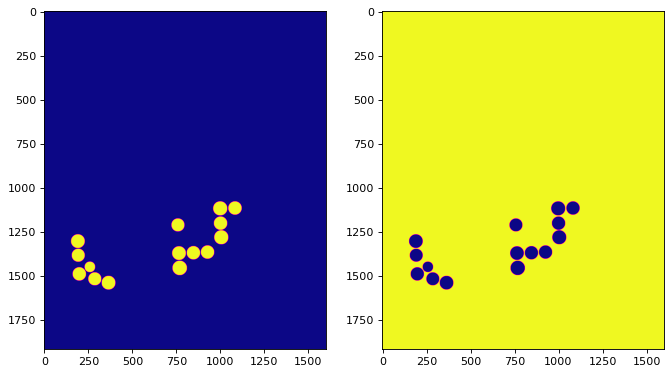

In [11]:
#Cria máscara para remover pivots da cena e para contabilizar estatisticas dos pivot
img_temp = ndvi
img_temp2 = ndvi
#IMAGEM BASE DE ZEROS
mask_piv = (np.zeros((img_temp.shape[0],img_temp.shape[1] ))*255).astype(np.uint8)
#CRIA CIRCULOS PARA REMOVER PIVOTS
for i in range(0, len(infos)):
  mask_piv = cv2.circle(mask_piv, ((infos[i][0],infos[i][1])), infos[i][2], (255, 255, 255), cv2.FILLED)

#cria mascara inversa
mask_piv_inv = np.invert(mask_piv)

#verifica mascara
plt.figure(figsize=(10, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(mask_piv, cmap='plasma')
plt.subplot(1,2,2)
plt.imshow(mask_piv_inv, cmap='plasma')
plt.show() 

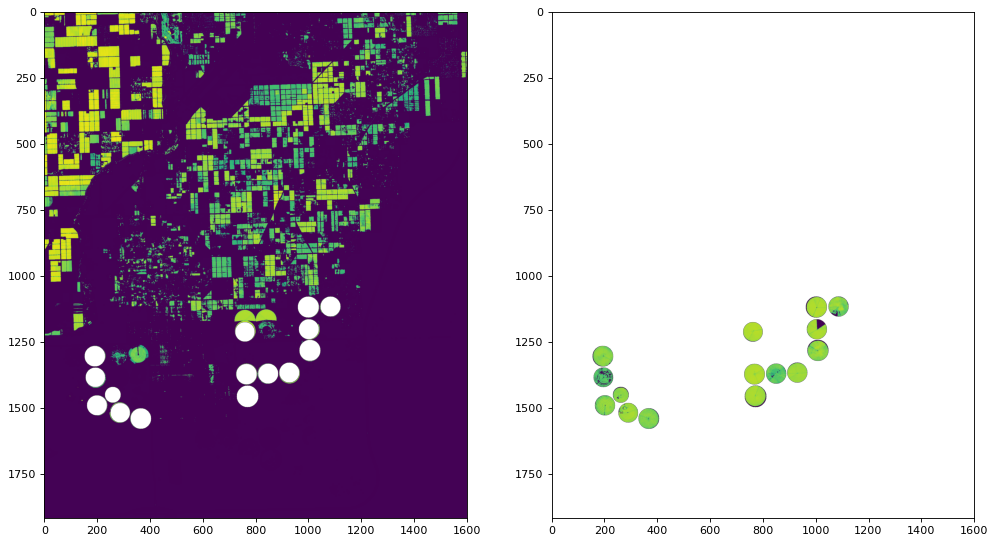

In [12]:
#IMAGEM SEM PIVOTS
img_sem_pivots = cv2.bitwise_and(img_temp, img_temp, mask=mask_piv_inv)

#IMAGEM SÓ PIVOTS
img_somente_pivots = cv2.bitwise_and(img_temp2, img_temp2, mask=mask_piv)

#verifica mascara
plt.figure(figsize=(15, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(img_sem_pivots, cmap='plasma')
plt.subplot(1,2,2)
plt.imshow(img_somente_pivots, cmap='plasma')
plt.show() 

Agricultura Convencional em relação à area total: 14.276740143194766 %
Agricultura com pivô cetral em relação à area total: 2.0816523284203234 %
Percentual Pivot em relação à area cultivada:  12.725286619894863 %
Percentual Convencional em relação à area cultivada:  87.27471338010514 %


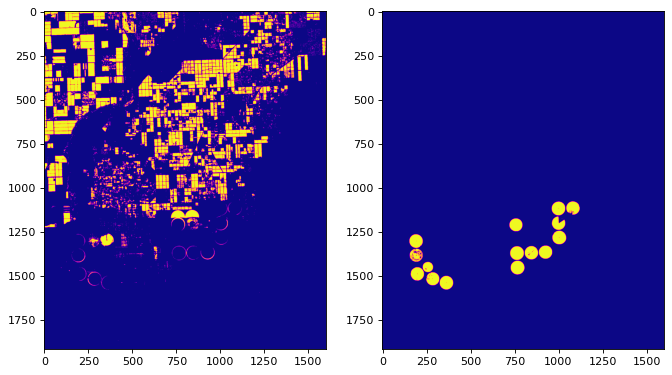

In [13]:
#Contabilizar estatisticas GERAIS DA IMAGEM (SEM PIVOTS)
img_sem_pivots = cv2.cvtColor(img_sem_pivots, cv2.COLOR_BGR2GRAY)
_,th4 = cv2.threshold((img_sem_pivots*255).astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

counter_1 = 0
counter_tot = th4.shape[0] * th4.shape[1] 
for i in range(0, th4.shape[0]):
  for j in range(0, th4.shape[1]):
    if th4[i][j] == 255:
      counter_1 = counter_1 + 1

percent_tot = (counter_1/counter_tot)
print("Agricultura Convencional em relação à area total:", percent_tot*100, "%")

#Contabilizar estatisticas dos pivots
img_somente_pivots = cv2.cvtColor(img_somente_pivots, cv2.COLOR_BGR2GRAY)
_,th5 = cv2.threshold((img_somente_pivots*255).astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

counter_1_piv = 0
for i in range(0, th5.shape[0]):
  for j in range(0, th5.shape[1]):
    if th5[i][j] == 255:
      counter_1_piv = counter_1_piv + 1

percent_piv = (counter_1_piv/counter_tot)
print("Agricultura com pivô cetral em relação à area total:", percent_piv*100, "%")

pcnt_piv = counter_1_piv/(counter_1 + counter_1_piv)
pcnt_conv = counter_1/(counter_1 + counter_1_piv)
print("Percentual Pivot em relação à area cultivada: ", pcnt_piv*100, "%")
print("Percentual Convencional em relação à area cultivada: ", pcnt_conv*100, "%")

plt.figure(figsize=(10, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(th4, cmap='plasma')
plt.subplot(1,2,2)
plt.imshow(th5, cmap='plasma')
plt.show() 

(1919, 1601)
(1919, 1601, 4)


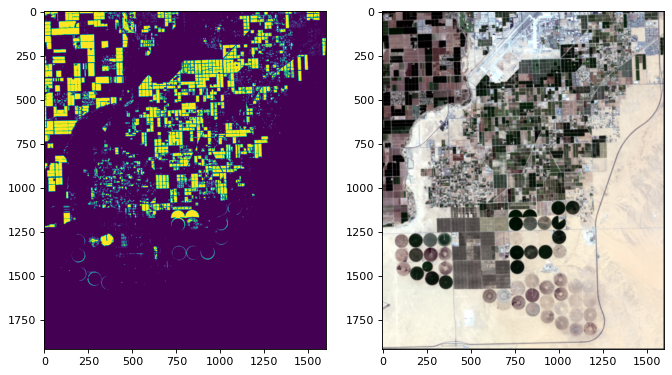

In [14]:
#Sobrepor pivots na imagem RGB

#gerar imagem RGB dessa area  --- GERAR EM TIFF e PNG
#adicionar area em ha de cada pivot em infos
#adicionar texto com area e numero e cor aleatória para cada pivot

rgb_yuma = plt.imread('YUMA_VALLEY_RGB.png', -1)
resized_rgb = cv2.resize(rgb_yuma, (th4.shape[1], th4.shape[0])) 
print(th4.shape)
print(resized_rgb.shape)
plt.figure(figsize=(10, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(th4)
plt.subplot(1,2,2)
plt.imshow(resized_rgb)
plt.show() 

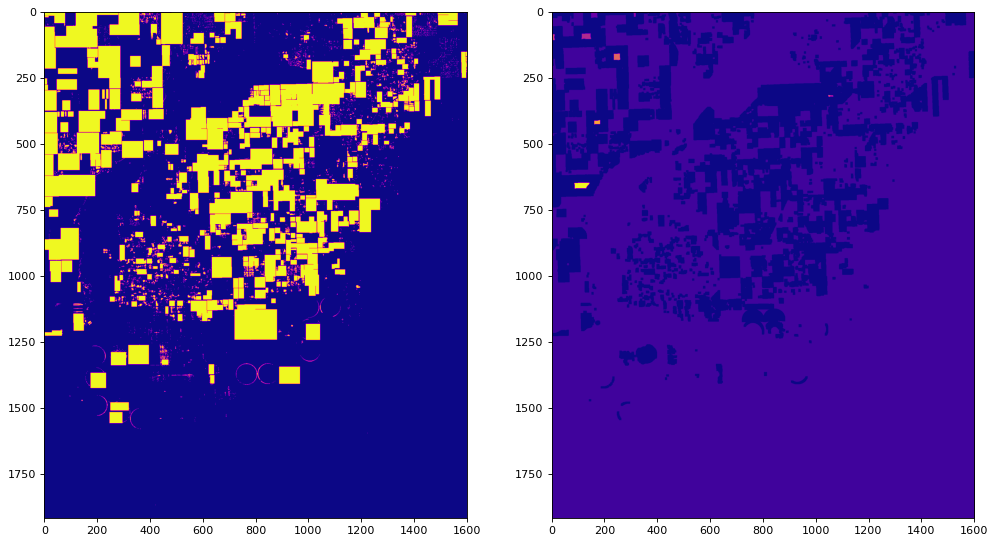

In [59]:
#TENTATIVA DE ACHAR AREA QUADRADAS PLANTADAS
img_rects = th4.copy()
img_rects_ws = th4.copy()
img_ws = th4.copy()

_,img_rects = cv2.threshold((img_rects*255).astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(img_rects, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

counter = 0
for c in contours:
  if cv2.contourArea(c) > 100:
    (x,y,w,h) = cv2.boundingRect(c)
    cv2.rectangle(img_rects, (x,y), (x+w,y+h), (255,255,255), -1)
    counter = counter + 1

##com watershed
#WATERSHED
#CORREÇÕES MORFOLÓGICAS

_,img_rects_ws = cv2.threshold((img_rects_ws*255).astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img_ws = rgb_yuma.copy()

# noise removal
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(img_rects_ws,cv2.MORPH_CLOSE,kernel, iterations = 1)
opening = cv2.morphologyEx(closing,cv2.MORPH_OPEN,kernel, iterations = 1)
#erosion = cv2.erode(opening, kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

#WATERSHED
#markers = cv2.watershed(plt.imread('YUMA_VALLEY_RGB.png'), markers)

plt.figure(figsize=(15, 15), dpi=80)
plt.subplot(1,2,1)
plt.imshow(img_rects, cmap='plasma')
plt.subplot(1,2,2)
plt.imshow(markers, cmap='plasma')
plt.show() 

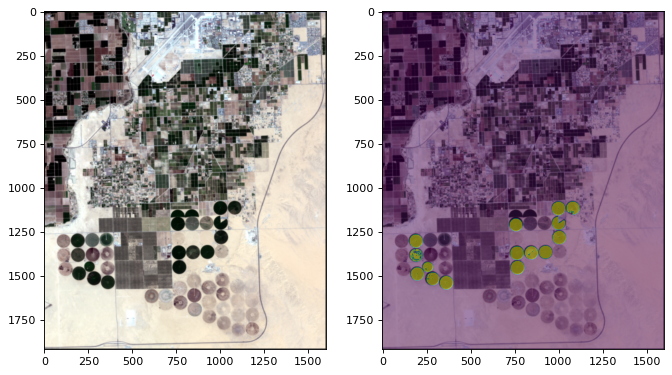

In [15]:

plt.figure(figsize=(10, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(resized_rgb)
plt.subplot(1,2,2)
plt.imshow(resized_rgb)
plt.imshow(th5, alpha=0.5)
plt.show() 

In [16]:
img_rgb = resized_rgb.copy()
overlay_circ = resized_rgb.copy()
overlay_num = resized_rgb.copy()
cores = []

for i in range(0, len(infos)):
  cores.append([])
  color1 = np.random.uniform(0, 1)
  cores.append(color1)
  color2 = np.random.uniform(0, 1)
  cores.append(color2)
  color3 = np.random.uniform(0, 1)
  cores.append(color3)
  #cv2.circle(overlay_circ, ((infos[i][0],infos[i][1])), infos[i][2], (color1, color2, color3, color1), cv2.FILLED)
  cv2.circle(overlay_circ, ((infos[i][0],infos[i][1])), infos[i][2], (0.2, 1, 0, color1), cv2.FILLED)

cv2.addWeighted(overlay_circ, 0.7, overlay_num, 1 - 0.7, 0, overlay_num)

for i in range(0, len(infos)):
  if i > 10:
    meio_raio = int(infos[i][2]/2)
  else:
    meio_raio = int(infos[i][2]/3)
  cv2.putText(overlay_num, str(i+1), ((infos[i][0]-meio_raio,infos[i][1]+meio_raio)), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)

cv2.addWeighted(overlay_num, 1, img_rgb, 1 - 1, 0, img_rgb)

array([[[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        ...,
        [0.06388409, 0.06917613, 0.08113067, 1.        ],
        [0.03989909, 0.04385862, 0.05181565, 1.        ],
        [0.03921569, 0.04313726, 0.05098039, 1.        ]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        ...,
        [0.06561323, 0.0710604 , 0.08350495, 1.        ],
        [0.04050333, 0.04450691, 0.0526762 , 1.        ],
        [0.03978788, 0.04375032, 0.05179781, 1.        ]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        ...,
        [0.12206923, 0.13258159, 0.16102523, 1.        ],
        [0.06023191, 0.065673

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


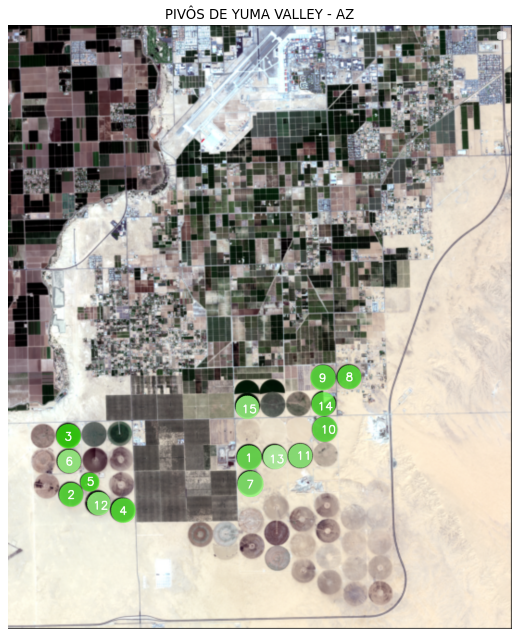

In [17]:
#GERA IMAGEM FINAL

plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("PIVÔS DE YUMA VALLEY - AZ")
plt.legend()
plt.show() 

In [18]:
#AREA TOTAL DA IMAGEM
area_img_ha = int((img_rgb.shape[0] * img_rgb.shape[1])/100)
print("Area total da imagem:", area_img_ha, "ha")

#AREA TOTAL CULTIVADA
area_cult_ha = int((counter_1 + counter_1_piv)/100)
print("Area total cultivada (Abril/2022):", area_cult_ha, "ha")

#AREA TOTAL CUTLIVADA CONVENCIONAL
area_conv_ha = int((counter_1)/100)
print("Area cultivada convencional (Abril/2022):", area_conv_ha, "ha")

#AREA TOTAL CUTLIVADA PIVO
area_piv_ha = int((counter_1_piv)/100)
print("Area cultivada por pivôs (Abril/2022):", area_piv_ha, "ha")

#AREA DE CADA PIVO
areas_piv_ha = []
for i in range(0, len(infos)):
  area_piv = int((3.1415*(infos[i][2])**2)/100)
  print("Pivô", (i+1), ":", area_piv, "ha")
  areas_piv_ha.append(area_piv)

Area total da imagem: 30723 ha
Area total cultivada (Abril/2022): 5025 ha
Area cultivada convencional (Abril/2022): 4386 ha
Area cultivada por pivôs (Abril/2022): 639 ha
Pivô 1 : 47 ha
Pivô 2 : 45 ha
Pivô 3 : 47 ha
Pivô 4 : 47 ha
Pivô 5 : 28 ha
Pivô 6 : 43 ha
Pivô 7 : 52 ha
Pivô 8 : 45 ha
Pivô 9 : 50 ha
Pivô 10 : 50 ha
Pivô 11 : 45 ha
Pivô 12 : 43 ha
Pivô 13 : 45 ha
Pivô 14 : 45 ha
Pivô 15 : 43 ha


In [19]:
print(areas_piv_ha)

[47, 45, 47, 47, 28, 43, 52, 45, 50, 50, 45, 43, 45, 45, 43]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


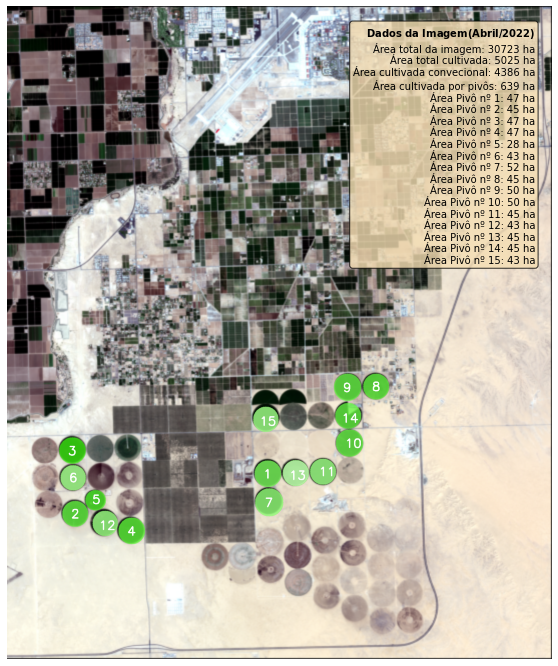

In [20]:
#PRODUTO FINAL
from matplotlib.pyplot import figure

#texto para a imagem
textstr = r"$\bf{Dados\ da\ Imagem (Abril/2022)}$" + '\n'
textstr = textstr + "Área total da imagem: " + str(area_img_ha) + " ha" + "\n"
textstr = textstr + "Área total cultivada: " + str(area_cult_ha) + " ha" + "\n"
textstr = textstr + "Área cultivada convecional: " + str(area_conv_ha) + " ha" + "\n"
textstr = textstr + "Área cultivada por pivôs: " + str(area_piv_ha) + " ha" + "\n"
for i in range(0, len(areas_piv_ha)):
        textstr  = textstr + "Área Pivô nº " + str(i+1) + ": " + str(areas_piv_ha[i]) + " ha" 
        if i != len(areas_piv_ha) - 1:
                textstr = textstr + "\n"
        
plt.rcParams["figure.figsize"] = (12,12)

fig, ax = plt.subplots()

ax.imshow(img_rgb)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.97, 0.97, textstr, transform=ax.transAxes, fontsize=10, horizontalalignment='right',
        verticalalignment='top', bbox=props)

ax.axis('off')
plt.show()